In [1]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
df = pd.read_csv('social_media_toxicity_dataset.csv')

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.15.1
astropy                       5.2.2
astunparse                    1.6.3
attrs                         23.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
blosc2                        2.0.0
bokeh                         2.4.3
branca                        0.6.0
CacheControl                  0.12.11
cached-property               1.5.2
cachetools                    5.3.0
cata

In [6]:
from tensorflow.keras.layers import TextVectorization

In [7]:
#split the data into comments and features
X = df['comment_text']
y = df[df.columns[2:]].values

In [8]:
#Total number of words part of our vocabulary
MAX_FEATURES = 200000

In [9]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [10]:
#learning the words which are part of our vocabulary
vectorizer.adapt(X.values)

In [11]:
vectorized_text = vectorizer(X.values)

In [12]:
#tensorflow data pipeline
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [13]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [15]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization

model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dropout(0.2))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               3

In [18]:
history = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
6981/6981 [==============================] - 724s 102ms/step - loss: 0.0724 - accuracy: 0.8953 - val_loss: 0.0534 - val_accuracy: 0.9939
Epoch 2/20
6981/6981 [==============================] - 590s 85ms/step - loss: 0.0513 - accuracy: 0.9534 - val_loss: 0.0442 - val_accuracy: 0.9941
Epoch 3/20
6981/6981 [==============================] - 585s 84ms/step - loss: 0.0461 - accuracy: 0.9755 - val_loss: 0.0436 - val_accuracy: 0.9947
Epoch 4/20
6981/6981 [==============================] - 576s 82ms/step - loss: 0.0427 - accuracy: 0.9789 - val_loss: 0.0422 - val_accuracy: 0.9944
Epoch 5/20
6981/6981 [==============================] - 570s 82ms/step - loss: 0.0402 - accuracy: 0.9934 - val_loss: 0.0888 - val_accuracy: 0.8539
Epoch 6/20
6981/6981 [==============================] - 572s 82ms/step - loss: 0.0376 - accuracy: 0.9898 - val_loss: 0.0987 - val_accuracy: 0.9940
Epoch 7/20
6981/6981 [==============================] - 579s 83ms/step - loss: 0.0357 - accuracy: 0.9853 - val_loss: 

In [19]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

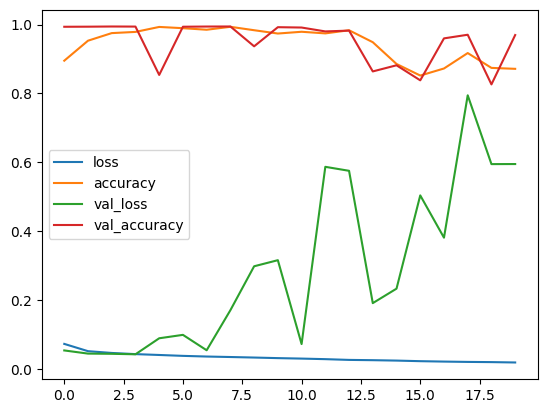

In [20]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [21]:
batch = test.as_numpy_iterator().next()

In [22]:
input_text = vectorizer('You are a pathetic moron, you sanctimonious piece of shit.')

In [23]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([ 7, 20,  6, ...,  0,  0,  0])>

In [24]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [25]:
model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 1s 710ms/step


array([[9.9987066e-01, 4.6219067e-03, 9.9536973e-01, 1.0048483e-04,
        9.9089819e-01, 5.9502921e-04]], dtype=float32)

In [26]:
res = model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 0s 55ms/step


In [27]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [28]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [29]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 62ms/step


array([[0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [30]:
res.shape

(1, 6)

In [31]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, AUC, BinaryAccuracy, FalsePositives, FalseNegatives

In [32]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()
auc = AUC()
bin_acc = BinaryAccuracy()
fp = FalsePositives()
fn = FalseNegatives()

In [33]:
for batch in test.as_numpy_iterator():
  # Unpack the batch 
  X_true, y_true = batch
  # Make a prediction 
  yhat = model.predict(X_true)
    
  # Flatten the predictions
  y_true = y_true.flatten()
  yhat = yhat.flatten()
    
  pre.update_state(y_true, yhat)
  re.update_state(y_true, yhat)
  acc.update_state(y_true, yhat)
  auc.update_state(y_true, yhat)
  bin_acc.update_state(y_true, yhat)
  fp.update_state(y_true, yhat)
  fn.update_state(y_true, yhat)

precision_result = pre.result().numpy()
recall_result = re.result().numpy()
accuracy_result = acc.result().numpy()
auc_result = auc.result().numpy()
bin_acc_result = bin_acc.result().numpy()
fp_result = fp.result().numpy()
fn_result = fn.result().numpy()

1/1 [==============================] - 0s 51ms/step


In [34]:
print(f'Precision: {precision_result}, Recall:{recall_result}, Accuracy:{accuracy_result}, AUC:{auc_result}, Bin Accuracy:{bin_acc_result}, False Positive: {fp_result}, False Negative: {fn_result}')

Precision: 0.932437002658844, Recall:0.7338624596595764, Accuracy:0.4774323105812073, AUC:0.9044609665870667, Bin Accuracy:0.9873892664909363, False Positive: 201.0, False Negative: 1006.0


In [35]:
!pip install gradio jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 78.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7

In [36]:
import tensorflow as tf
import gradio as gr

In [37]:
def score_comment(comment):

  vectorized_comment = vectorizer([comment])
  results = model.predict(vectorized_comment)
    
  text = ''
  for idx, col in enumerate(df.columns[2:]):
    text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
  return text

In [38]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

/usr/local/lib/python3.9/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [39]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://42bad2bdcc2a55f5b0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
